In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [118]:
data = pd.read_csv('ab_browser_test.csv')

In [119]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [120]:
data.shape

(566134, 6)

In [121]:
exp = data[data.slot == 'exp']
control = data[data.slot == 'control']

In [122]:
exp_clicks = np.sum(exp.n_clicks)
cntrl_clicks = np.sum(control.n_clicks)

In [123]:
round((exp_clicks - cntrl_clicks) / cntrl_clicks * 100, 3) #1

1.614

In [124]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [125]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [126]:
np.random.seed(0)

exp_mean_scores = np.array(list(map(np.mean, get_bootstrap_samples(exp.n_clicks.values, 1000))))
cntrl_mean_scores = np.array(list(map(np.mean, get_bootstrap_samples(control.n_clicks.values, 1000))))

print("95% confidence interval for the ILEC mean repair time:",  stat_intervals(exp_mean_scores - cntrl_mean_scores, 0.05))

95% confidence interval for the ILEC mean repair time: [0.19172563 0.40475697]


In [127]:
np.random.seed(0)

exp_median_scores = np.array(list(map(np.median, get_bootstrap_samples(exp.n_clicks.values, 1000))))
cntrl_median_scores = np.array(list(map(np.median, get_bootstrap_samples(control.n_clicks.values, 1000))))

print("95% confidence interval for the ILEC mean repair time:",  stat_intervals(exp_median_scores - cntrl_median_scores, 0.05))

95% confidence interval for the ILEC mean repair time: [1. 1.]


In [44]:
np.random.seed(0)
n_boot_samples = 500

arr = get_bootstrap_samples(control.n_clicks.values, n_boot_samples)
control_mean_scores = np.mean(arr, axis=1)

In [47]:
control_var_scores = np.var(arr, axis=1)

(6.595310559918906, 411.6231633787497, 0.9982231051771374)

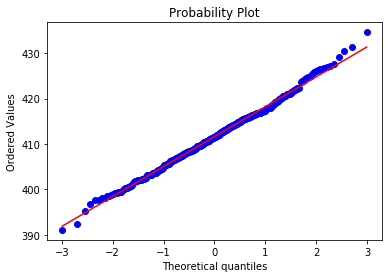

In [61]:
stats.probplot(control_var_scores, dist="norm", plot=plt)[1]

(0.20886662879794235, 307.4001265880713, 0.9986416698820314)

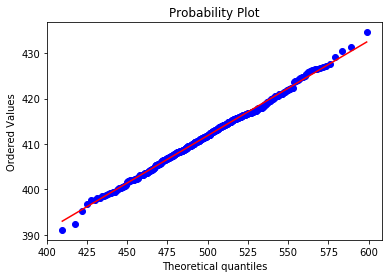

In [59]:
scipy.stats.probplot(control_var_scores, dist="chi2", 
                     sparams=(n_boot_samples-1), plot=plt)[1] #4

In [73]:
exp[exp.userID == 61050]

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
58265,61050,Browser #2,exp,0,1,1
58266,61050,Browser #22,exp,20,30,17


In [116]:
exp_res = exp.pivot_table(values='n_clicks', index='userID', aggfunc='sum')
control_res = control.pivot_table(values='n_clicks', index='userID', aggfunc='sum')

In [117]:
stats.mannwhitneyu(exp_res, control_res, alternative='two-sided')

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

In [97]:
browsers = data.browser.unique()
browsers

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

In [113]:
p_values = []
percent_clicks_exp = []
percent_clicks_control = []
for i in browsers:
    percent_clicks_control.append(np.sum(control[control.browser == i].n_nonclk_queries) * 100\
                                  / np.sum(control[control.browser == i].n_queries))
    percent_clicks_exp.append(np.sum(exp[exp.browser == i].n_nonclk_queries) * 100 / np.sum(exp[exp.browser == i].n_queries))
    p_values.append(stats.mannwhitneyu(exp[exp.browser == i].n_clicks, control[control.browser == i].n_clicks,\
                                       alternative='two-sided').pvalue)

In [115]:
percent_clicks_control, percent_clicks_exp

([45.96274717919465,
  46.97092963514274,
  57.59041136008114,
  36.29936674628209,
  40.540484743383296,
  40.593976593513354],
 [44.982746948554706,
  45.14294190358467,
  43.755617361273295,
  36.93741284866483,
  38.97737648371716,
  39.85394721969546])

In [96]:
p_values #6

[0.0544877208394482,
 0.8152123531690997,
 0.0,
 0.07480120286021603,
 0.9073331277747075,
 0.5148110304420064]

In [98]:
import statsmodels.stats.multitest as smm

In [99]:
reject, p_corrected, a1, a2 = smm.multipletests(p_values, alpha=0.05, method='holm')

In [100]:
p_corrected

array([0.2724386 , 1.        , 0.        , 0.29920481, 1.        ,
       1.        ])

In [102]:
exp.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
4,7,Browser #4,exp,54,68,30
6,9,Browser #4,exp,6,3,1
